## Pneumonia Detection : ResNet50 (PyTorch + AMP)

## Mixed precision, OneCycleLR, class weights, AUC/F1, threshold tuning

I begin by checking torch version for GPU acceleration 

In [9]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Torch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


Imports 

In [10]:

import os, math, time, json, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from collections import defaultdict

# Repro + GPU prefs
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True           # enable autotuner for convs
torch.backends.cuda.matmul.allow_tf32 = True    # Ampere+ TF32 (speed)
torch.backends.cudnn.allow_tf32 = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch", torch.__version__, "| CUDA?", torch.cuda.is_available(), "| Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Torch 2.5.1+cu121 | CUDA? True | Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


Defining Hyperparameters 

In [ ]:

DATA_ROOT = r"D:\pneumonia_detection_model\dataset"  # train/val/test structure
OUTPUT_DIR = Path("./runs_resnet50")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Training hyperparams
EPOCHS = 60        
BATCH  = 32
IMG_SIZE = 224
BASE_LR = 3e-4     # OneCycleLR peak LR
WD = 1e-4
NUM_WORKERS = min(8, os.cpu_count() or 4)
ALLOW_HFLIP = False  # CXR lateral info—keep False w


In [ ]:
# ImageNet normalization (ResNet50 pretrain)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(p=0.0 if not ALLOW_HFLIP else 0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = tv.datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_tfms)
val_ds   = tv.datasets.ImageFolder(os.path.join(DATA_ROOT, "val"),   transform=eval_tfms)
test_ds  = tv.datasets.ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=eval_tfms)

IDX2CLASS = {v:k for k,v in train_ds.class_to_idx.items()}
print("Classes:", train_ds.class_to_idx)
print("Counts — train:", len(train_ds), " val:", len(val_ds), " test:", len(test_ds))


Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Counts — train: 4434  val: 782  test: 624


In [13]:
# Compute per-class counts from train set to build BCE weights
from collections import Counter
train_targets = [y for _, y in train_ds.samples]
class_counts = Counter(train_targets)
num_pos = class_counts[train_ds.class_to_idx['PNEUMONIA']]
num_neg = class_counts[train_ds.class_to_idx['NORMAL']]
print("Train counts:", {IDX2CLASS[k]: v for k,v in class_counts.items()})

# Positive class weight = neg/pos so that BCE balances contributions
pos_weight = torch.tensor([num_neg / max(1, num_pos)], device=device, dtype=torch.float32)
print("pos_weight:", pos_weight.item())


Train counts: {'NORMAL': 1140, 'PNEUMONIA': 3294}
pos_weight: 0.34608379006385803


In [14]:
# %%
pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin)

steps_per_epoch = math.ceil(len(train_loader))
print("Steps/epoch:", steps_per_epoch)


Steps/epoch: 139


In [15]:
# Pretrained ResNet50
weights = tv.models.ResNet50_Weights.IMAGENET1K_V2
model = tv.models.resnet50(weights=weights)
# Replace classification head with binary logit
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 1)
model = model.to(device)

# Loss: BCEWithLogits with pos_weight for imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer & LR schedule
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=BASE_LR,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.1,
    div_factor=10.0,
    final_div_factor=1e4,
    anneal_strategy='cos'
)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
best_val_auc = -1.0
PATIENCE = 6
epochs_no_improve = 0
ckpt_path = OUTPUT_DIR / "best_resnet50.pt"

sum(p.numel() for p in model.parameters())/1e6


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1706157300.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


23.510081

In [16]:
# %%
@torch.no_grad()
def collect_probs(model, loader):
    model.eval()
    all_logits, all_targets = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).float()
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x).squeeze(1)
        all_logits.append(logits.detach().float().cpu().numpy())
        all_targets.append(y.cpu().numpy())
    logits = np.concatenate(all_logits)
    targets = np.concatenate(all_targets).astype(int)
    probs = 1.0 / (1.0 + np.exp(-logits))
    return targets, probs

def metrics_from_probs(y_true, p, threshold):
    y_hat = (p >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    sens = tp / (tp + fn + 1e-9)                         # recall
    spec = tn / (tn + fp + 1e-9)
    acc  = accuracy_score(y_true, y_hat)
    f1   = f1_score(y_true, y_hat)
    prec = precision_score(y_true, y_hat, zero_division=0)
    rec  = recall_score(y_true, y_hat)
    auc  = roc_auc_score(y_true, p)
    return dict(AUC=auc, F1=f1, Accuracy=acc, Precision=prec, Recall=rec, Specificity=spec,
                TP=int(tp), TN=int(tn), FP=int(fp), FN=int(fn), Threshold=float(threshold))

def best_f1_threshold(y_true, p):
    ts = np.linspace(0.05, 0.95, 19)
    f1s = [f1_score(y_true, (p>=t).astype(int)) for t in ts]
    return float(ts[int(np.argmax(f1s))]), float(max(f1s))

@torch.no_grad()
def evaluate_val(model, val_loader):
    y, p = collect_probs(model, val_loader)
    t_best, f1_best = best_f1_threshold(y, p)
    m = metrics_from_probs(y, p, t_best)
    return m, t_best

@torch.no_grad()
def evaluate_test(model, test_loader, threshold):
    y, p = collect_probs(model, test_loader)
    m = metrics_from_probs(y, p, threshold)
    return m


In [17]:
def train_one_epoch(model, loader, optimizer, scaler, scheduler):
    model.train()
    running = defaultdict(float)
    n = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x).squeeze(1)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        bs = x.size(0)
        running["loss"] += loss.item() * bs
        n += bs

    return {k: v/max(1,n) for k,v in running.items()}

history = {"train_loss": [], "val_auc": [], "val_f1": [], "lr": []}
start = time.time()
best_pack = {}

for epoch in range(1, EPOCHS+1):
    tr = train_one_epoch(model, train_loader, optimizer, scaler, scheduler)
    history["train_loss"].append(tr["loss"])
    history["lr"].append(scheduler.get_last_lr()[0])

    val_metrics, t_best = evaluate_val(model, val_loader)
    history["val_auc"].append(val_metrics["AUC"])
    history["val_f1"].append(val_metrics["F1"])

    print(f"[{epoch:03d}/{EPOCHS}] loss={tr['loss']:.4f} | "
          f"val AUC={val_metrics['AUC']:.4f} F1={val_metrics['F1']:.4f} "
          f"Rec={val_metrics['Recall']:.4f} Spec={val_metrics['Specificity']:.4f} thr={t_best:.2f}")

    # Early stopping on AUC
    if val_metrics["AUC"] > best_val_auc:
        best_val_auc = val_metrics["AUC"]
        epochs_no_improve = 0
        best_pack = {"epoch": epoch, "threshold": t_best, "val": val_metrics}
        torch.save({"model": model.state_dict(),
                    "class_to_idx": train_ds.class_to_idx,
                    "epoch": epoch,
                    "threshold": t_best}, ckpt_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stop at epoch {epoch} (no AUC improve {PATIENCE} epochs).")
            break

dur_min = (time.time() - start)/60.0
print(f"Training finished in {dur_min:.1f} min.")
print("Best @ epoch", best_pack.get("epoch"), " | Val:", best_pack.get("val"))
print("Saved:", ckpt_path)


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
d:\pneumonia_detection_model\x-ray\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.

[001/60] loss=0.1799 | val AUC=0.9903 F1=0.9737 Rec=0.9862 Spec=0.8856 thr=0.05


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[002/60] loss=0.0578 | val AUC=0.9970 F1=0.9862 Rec=0.9845 Spec=0.9652 thr=0.10


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[003/60] loss=0.0411 | val AUC=0.9973 F1=0.9863 Rec=0.9931 Spec=0.9403 thr=0.10


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[004/60] loss=0.0428 | val AUC=0.9958 F1=0.9880 Rec=0.9948 Spec=0.9453 thr=0.30


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[005/60] loss=0.0423 | val AUC=0.9977 F1=0.9854 Rec=0.9862 Spec=0.9552 thr=0.05


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[006/60] loss=0.0384 | val AUC=0.9978 F1=0.9846 Rec=0.9897 Spec=0.9403 thr=0.05


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[007/60] loss=0.0223 | val AUC=0.9977 F1=0.9871 Rec=0.9862 Spec=0.9652 thr=0.10


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[008/60] loss=0.0191 | val AUC=0.9978 F1=0.9781 Rec=0.9587 Spec=0.9950 thr=0.05


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[009/60] loss=0.0173 | val AUC=0.9969 F1=0.9863 Rec=0.9880 Spec=0.9552 thr=0.05


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[010/60] loss=0.0218 | val AUC=0.9973 F1=0.9818 Rec=0.9725 Spec=0.9751 thr=0.05


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[011/60] loss=0.0257 | val AUC=0.9968 F1=0.9829 Rec=0.9914 Spec=0.9254 thr=0.05


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1728753565.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[012/60] loss=0.0210 | val AUC=0.9977 F1=0.9887 Rec=0.9811 Spec=0.9900 thr=0.10
Early stop at epoch 12 (no AUC improve 6 epochs).
Training finished in 8.7 min.
Best @ epoch 6  | Val: {'AUC': 0.9978164256171809, 'F1': 0.9845890410958904, 'Accuracy': 0.9769820971867008, 'Precision': 0.979557069846678, 'Recall': 0.9896729776247849, 'Specificity': np.float64(0.9402985074580085), 'TP': 575, 'TN': 189, 'FP': 12, 'FN': 6, 'Threshold': 0.05}
Saved: runs_resnet50\best_resnet50.pt


In [18]:
# Load best weights
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])
best_thr = float(ckpt.get("threshold", 0.5))

test_metrics = evaluate_test(model, test_loader, best_thr)
print("Test metrics (using val-best threshold):")
print(json.dumps(test_metrics, indent=2))


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2548414211.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)
C:\

Test metrics (using val-best threshold):
{
  "AUC": 0.9809555117247426,
  "F1": 0.8549450549450549,
  "Accuracy": 0.7884615384615384,
  "Precision": 0.7480769230769231,
  "Recall": 0.9974358974358974,
  "Specificity": 0.4401709401690591,
  "TP": 389,
  "TN": 103,
  "FP": 131,
  "FN": 1,
  "Threshold": 0.05
}


In [19]:
# TorchScript (CPU/GPU-agnostic)
example = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)
model.eval()
traced = torch.jit.trace(model, example)
ts_path = OUTPUT_DIR / "resnet50_pneumonia_traced.pt"
traced.save(str(ts_path))
print("Saved TorchScript to:", ts_path)

# Persist history + best/ test metrics
with open(OUTPUT_DIR / "train_history.json", "w") as f:
    json.dump(history, f, indent=2)
with open(OUTPUT_DIR / "best_val.json", "w") as f:
    json.dump(best_pack, f, indent=2)
with open(OUTPUT_DIR / "test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=2)
print("Saved metrics JSONs to:", OUTPUT_DIR)


Saved TorchScript to: runs_resnet50\resnet50_pneumonia_traced.pt
Saved metrics JSONs to: runs_resnet50


In [20]:
# Compute and cache probabilities/labels for val & test
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
import numpy as np

y_val, p_val = collect_probs(model, val_loader)
y_test, p_test = collect_probs(model, test_loader)

val_auc  = roc_auc_score(y_val, p_val)
test_auc = roc_auc_score(y_test, p_test)
val_ap   = average_precision_score(y_val, p_val)
test_ap  = average_precision_score(y_test, p_test)

print(f"Val  AUC={val_auc:.4f} | AP={val_ap:.4f}")
print(f"Test AUC={test_auc:.4f} | AP={test_ap:.4f}")


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\2737238313.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Val  AUC=0.9978 | AP=0.9992
Test AUC=0.9810 | AP=0.9861


Best-F1 threshold on val: 0.05

VAL @ t*: {'F1': 0.9845890410958904, 'Precision': 0.979557069846678, 'Recall': np.float64(0.9896729776230815), 'Specificity': np.float64(0.9402985074580085), 'Accuracy': 0.9769820971867008, 'AUC': 0.9978164256171809, 'TP': 575, 'TN': 189, 'FP': 12, 'FN': 6}

TEST @ t*: {'F1': 0.8549450549450549, 'Precision': 0.7480769230769231, 'Recall': np.float64(0.9974358974333399), 'Specificity': np.float64(0.4401709401690591), 'Accuracy': 0.7884615384615384, 'AUC': 0.9809555117247426, 'TP': 389, 'TN': 103, 'FP': 131, 'FN': 1}


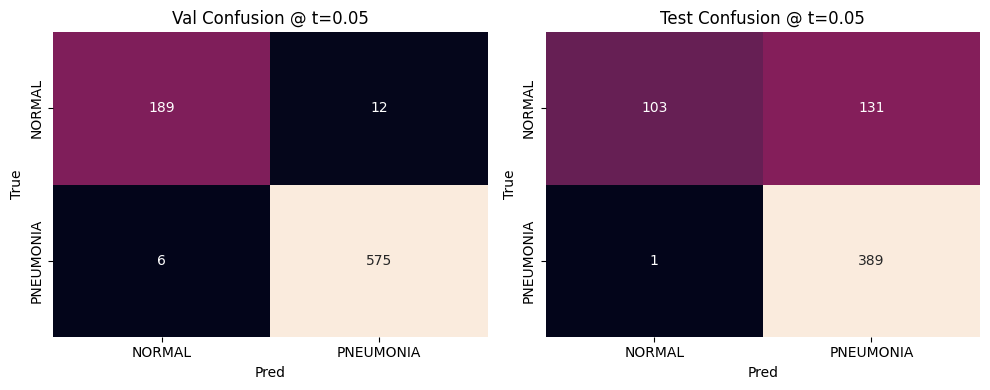

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

# Choose threshold on val by best F1
thr_vals = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_val, (p_val>=t).astype(int)) for t in thr_vals]
t_best = float(thr_vals[int(np.argmax(f1s))])
print("Best-F1 threshold on val:", t_best)

# Metrics on val at t_best
def metrics(y_true, p, t):
    y_hat = (p>=t).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    tn, fp, fn, tp = cm.ravel()
    sens = tp/(tp+fn+1e-9)
    spec = tn/(tn+fp+1e-9)
    return dict(
        F1=f1_score(y_true, y_hat),
        Precision=precision_score(y_true, y_hat, zero_division=0),
        Recall=sens,
        Specificity=spec,
        Accuracy=accuracy_score(y_true, y_hat),
        AUC=roc_auc_score(y_true, p),
        TP=int(tp), TN=int(tn), FP=int(fp), FN=int(fn)
    ), cm

val_m, val_cm = metrics(y_val, p_val, t_best)
test_m, test_cm = metrics(y_test, p_test, t_best)

print("\nVAL @ t*:", val_m)
print("\nTEST @ t*:", test_m)

# Confusion matrices
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(val_cm, annot=True, fmt="d", cbar=False, ax=axes[0])
axes[0].set_title(f"Val Confusion @ t={t_best:.2f}")
axes[0].set_xlabel("Pred"); axes[0].set_ylabel("True")
axes[0].set_xticklabels(["NORMAL","PNEUMONIA"]); axes[0].set_yticklabels(["NORMAL","PNEUMONIA"])

sns.heatmap(test_cm, annot=True, fmt="d", cbar=False, ax=axes[1])
axes[1].set_title(f"Test Confusion @ t={t_best:.2f}")
axes[1].set_xlabel("Pred"); axes[1].set_ylabel("True")
axes[1].set_xticklabels(["NORMAL","PNEUMONIA"]); axes[1].set_yticklabels(["NORMAL","PNEUMONIA"])
plt.tight_layout(); plt.show()


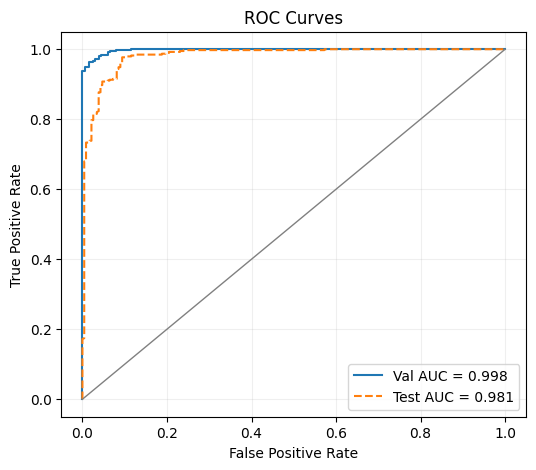

In [22]:
from sklearn.metrics import roc_curve

fpr_v, tpr_v, _ = roc_curve(y_val,  p_val)
fpr_t, tpr_t, _ = roc_curve(y_test, p_test)

plt.figure(figsize=(6,5))
plt.plot(fpr_v, tpr_v, label=f"Val AUC = {val_auc:.3f}")
plt.plot(fpr_t, tpr_t, label=f"Test AUC = {test_auc:.3f}", linestyle="--")
plt.plot([0,1],[0,1], color="gray", linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend(); plt.grid(alpha=0.2); plt.show()


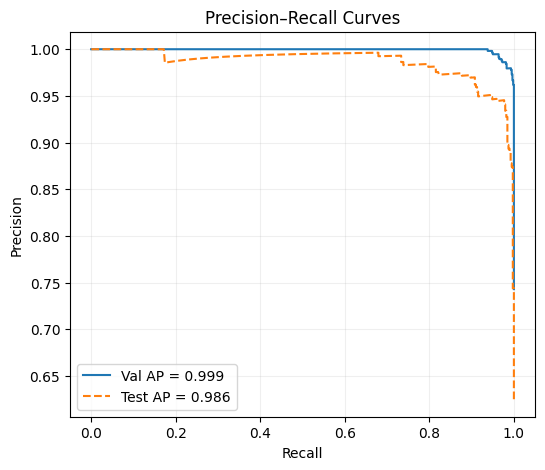

In [23]:
from sklearn.metrics import precision_recall_curve

prec_v, rec_v, _ = precision_recall_curve(y_val,  p_val)
prec_t, rec_t, _ = precision_recall_curve(y_test, p_test)

plt.figure(figsize=(6,5))
plt.plot(rec_v, prec_v, label=f"Val AP = {val_ap:.3f}")
plt.plot(rec_t, prec_t, label=f"Test AP = {test_ap:.3f}", linestyle="--")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves"); plt.legend(); plt.grid(alpha=0.2); plt.show()


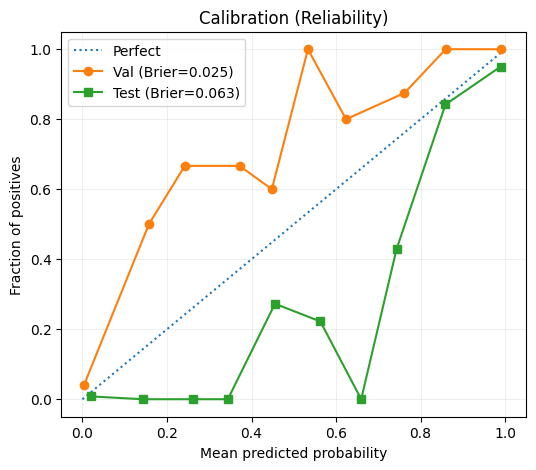

In [24]:
# Reliability curves
prob_true_v, prob_pred_v = calibration_curve(y_val,  p_val, n_bins=10, strategy="uniform")
prob_true_t, prob_pred_t = calibration_curve(y_test, p_test, n_bins=10, strategy="uniform")
brier_v = brier_score_loss(y_val,  p_val)
brier_t = brier_score_loss(y_test, p_test)

plt.figure(figsize=(6,5))
plt.plot([0,1], [0,1], linestyle=":", label="Perfect")
plt.plot(prob_pred_v, prob_true_v, marker="o", label=f"Val (Brier={brier_v:.3f})")
plt.plot(prob_pred_t, prob_true_t, marker="s", label=f"Test (Brier={brier_t:.3f})")
plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Calibration (Reliability)"); plt.legend(); plt.grid(alpha=0.2); plt.show()


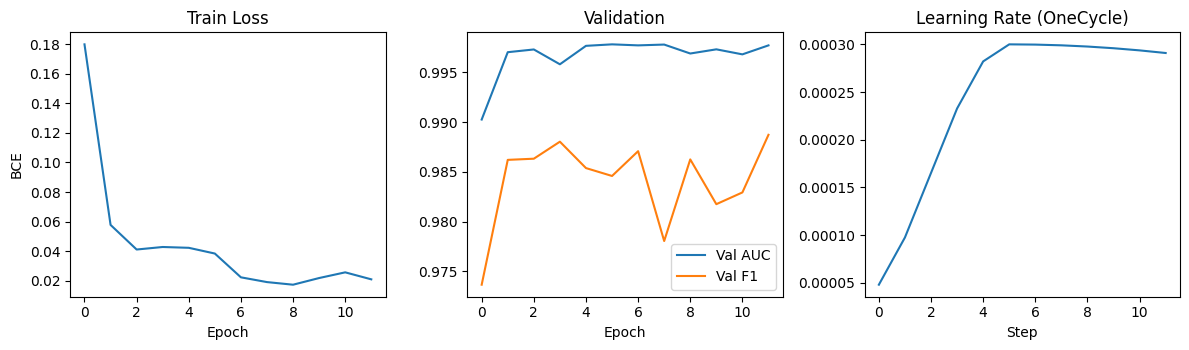

In [25]:
import json, os

# history is in-memory from training; if missing, try loading from file
if not ("history" in globals() and isinstance(history, dict)):
    hist_path = OUTPUT_DIR / "train_history.json"
    if hist_path.exists():
        with open(hist_path) as f:
            history = json.load(f)
    else:
        history = {}

plt.figure(figsize=(12,3.6))
plt.subplot(1,3,1)
plt.plot(history.get("train_loss", []))
plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("BCE")

plt.subplot(1,3,2)
plt.plot(history.get("val_auc", []), label="Val AUC")
plt.plot(history.get("val_f1", []),  label="Val F1")
plt.title("Validation"); plt.xlabel("Epoch"); plt.legend()

plt.subplot(1,3,3)
plt.plot(history.get("lr", []))
plt.title("Learning Rate (OneCycle)"); plt.xlabel("Step")
plt.tight_layout(); plt.show()


In [26]:
# %% Generate report assets + summary JSON for README authoring
import os, json, math, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, confusion_matrix, f1_score, precision_score, recall_score,
    accuracy_score, brier_score_loss
)
from sklearn.calibration import calibration_curve
import torch

# ---------------- Paths & helpers ----------------
OUT = (OUTPUT_DIR if 'OUTPUT_DIR' in globals() else Path("./runs_resnet50"))
ASSETS = OUT / "report_assets"
ASSETS.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval();

# If these exist from earlier:
def _safe(v, default=None): 
    return v if v is not None else default

IMG_SIZE = _safe(globals().get("IMG_SIZE"), 224)
ALLOW_HFLIP = bool(_safe(globals().get("ALLOW_HFLIP"), False))
pos_weight_val = float(_safe(globals().get("pos_weight"), torch.tensor([1.0])).item())

# Class names
if 'train_ds' in globals():
    IDX2CLASS = {v:k for k,v in train_ds.class_to_idx.items()}
    CLASSES = [IDX2CLASS[i] for i in sorted(IDX2CLASS)]
else:
    CLASSES = ["NORMAL","PNEUMONIA"]

# --------------- Collect probs ---------------
@torch.no_grad()
def collect_probs(m, loader):
    ys, ps = [], []
    for x,y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).float()
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logit = m(x).squeeze(1)
        p = torch.sigmoid(logit)
        ys.append(y.detach().cpu().numpy())
        ps.append(p.detach().cpu().numpy())
    return np.concatenate(ys).astype(int), np.concatenate(ps)

y_val, p_val = collect_probs(model, val_loader)
y_test, p_test = collect_probs(model, test_loader)

# --------------- Threshold, metrics ---------------
def metrics_at(y_true, p, thr):
    y_hat = (p >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    tn, fp, fn, tp = cm.ravel()
    sens = tp/(tp+fn+1e-9)
    spec = tn/(tn+fp+1e-9)
    return {
        "AUC": float(roc_auc_score(y_true, p)),
        "AP":  float(average_precision_score(y_true, p)),
        "F1":  float(f1_score(y_true, y_hat)),
        "Precision": float(precision_score(y_true, y_hat, zero_division=0)),
        "Recall": float(sens),
        "Specificity": float(spec),
        "Accuracy": float(accuracy_score(y_true, y_hat)),
        "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "Threshold": float(thr),
    }, cm

# Choose val threshold by best F1
thr_grid = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_val, (p_val>=t).astype(int)) for t in thr_grid]
t_best = float(thr_grid[int(np.argmax(f1s))])

val_metrics, val_cm = metrics_at(y_val, p_val, t_best)
test_metrics, test_cm = metrics_at(y_test, p_test, t_best)

# --------------- Plots ---------------
# ROC
fpr_v, tpr_v, _ = roc_curve(y_val, p_val)
fpr_t, tpr_t, _ = roc_curve(y_test, p_test)
plt.figure(figsize=(6,5))
plt.plot(fpr_v, tpr_v, label=f"Val AUC={val_metrics['AUC']:.3f}")
plt.plot(fpr_t, tpr_t, '--', label=f"Test AUC={test_metrics['AUC']:.3f}")
plt.plot([0,1],[0,1], c='gray', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend(); plt.grid(alpha=0.2)
roc_path = ASSETS / "roc.png"; plt.tight_layout(); plt.savefig(roc_path, dpi=140); plt.close()

# PR
prec_v, rec_v, _ = precision_recall_curve(y_val, p_val)
prec_t, rec_t, _ = precision_recall_curve(y_test, p_test)
plt.figure(figsize=(6,5))
plt.plot(rec_v, prec_v, label=f"Val AP={val_metrics['AP']:.3f}")
plt.plot(rec_t, prec_t, '--', label=f"Test AP={test_metrics['AP']:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall"); plt.legend(); plt.grid(alpha=0.2)
pr_path = ASSETS / "pr.png"; plt.tight_layout(); plt.savefig(pr_path, dpi=140); plt.close()

# Calibration
brier_v = brier_score_loss(y_val, p_val)
brier_t = brier_score_loss(y_test, p_test)
prob_true_v, prob_pred_v = calibration_curve(y_val, p_val, n_bins=10, strategy="uniform")
prob_true_t, prob_pred_t = calibration_curve(y_test, p_test, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,5))
plt.plot([0,1], [0,1], ':', label="Perfect")
plt.plot(prob_pred_v, prob_true_v, 'o-', label=f"Val (Brier={brier_v:.3f})")
plt.plot(prob_pred_t, prob_true_t, 's-', label=f"Test (Brier={brier_t:.3f})")
plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Calibration (Reliability)"); plt.legend(); plt.grid(alpha=0.2)
cal_path = ASSETS / "calibration.png"; plt.tight_layout(); plt.savefig(cal_path, dpi=140); plt.close()

# Confusion matrices
def _cm_plot(cm, title, path):
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.savefig(path, dpi=140); plt.close()
_cm_plot(val_cm, f"Val @ t={t_best:.2f}", ASSETS / "cm_val.png")
_cm_plot(test_cm, f"Test @ t={t_best:.2f}", ASSETS / "cm_test.png")

# Learning curves (if history exists)
lc_path = None
if 'history' in globals() and isinstance(history, dict) and history.get("train_loss"):
    plt.figure(figsize=(11,3.5))
    plt.subplot(1,3,1); plt.plot(history["train_loss"]); plt.title("Train Loss"); plt.xlabel("Epoch"); plt.ylabel("BCE")
    plt.subplot(1,3,2); 
    if "val_auc" in history: plt.plot(history["val_auc"], label="Val AUC")
    if "val_f1"  in history: plt.plot(history["val_f1"],  label="Val F1")
    plt.title("Validation"); plt.xlabel("Epoch"); plt.legend()
    plt.subplot(1,3,3); 
    if "lr" in history: plt.plot(history["lr"]); plt.title("Learning Rate"); plt.xlabel("Step")
    lc_path = ASSETS / "learning_curves.png"
    plt.tight_layout(); plt.savefig(lc_path, dpi=140); plt.close()

# --------------- Training/Model info ---------------
# Try to pull best epoch/threshold from saved ckpt or JSON
best_epoch = None
best_thr_ckpt = None
for cand in [OUT/"best_val.json", OUT/"best_resnet50.pt"]:
    if Path(cand).suffix == ".json" and Path(cand).exists():
        try:
            with open(cand) as f:
                j = json.load(f)
                best_epoch = j.get("epoch", best_epoch)
                best_thr_ckpt = j.get("threshold", best_thr_ckpt)
        except: pass
    elif Path(cand).suffix == ".pt" and Path(cand).exists():
        try:
            ck = torch.load(cand, map_location="cpu")
            best_epoch = ck.get("epoch", best_epoch)
            best_thr_ckpt = ck.get("threshold", best_thr_ckpt)
        except: pass

# Count params
n_params = None
try:
    n_params = sum(p.numel() for p in model.parameters())
except: 
    n_params = None

# Dataset counts
def ds_count(ds):
    try:
        return len(ds)
    except: return None

counts = {
    "train": ds_count(globals().get("train_ds")),
    "val":   ds_count(globals().get("val_ds")),
    "test":  ds_count(globals().get("test_ds")),
    "train_class_counts": None
}

try:
    # tv.datasets.ImageFolder keeps samples as (path, class_idx)
    from collections import Counter
    train_targets = [y for _,y in train_ds.samples]
    idx2 = {v:k for k,v in train_ds.class_to_idx.items()}
    cc = Counter(train_targets)
    counts["train_class_counts"] = {idx2[k]: int(v) for k,v in cc.items()}
except:
    pass

# --------------- Build summary ---------------
summary = {
    "preprocessing": {
        "resize": f"{IMG_SIZE}x{IMG_SIZE}",
        "normalize": "ImageNet mean/std",
        "augmentations": f"RandomResizedCrop, small rotation, horizontal_flip={'ON' if ALLOW_HFLIP else 'OFF'}"
    },
    "model": {
        "arch": "ResNet50 (ImageNet pretrained), FC->1 logit",
        "params": n_params,
        "loss": f"BCEWithLogitsLoss(pos_weight={pos_weight_val:.3f})",
        "mixed_precision_amp": True,
        "tf32": True
    },
    "training": {
        "optimizer": "AdamW",
        "scheduler": "OneCycleLR",
        "epochs_requested": int(globals().get("EPOCHS", 0)),
        "best_epoch": int(best_epoch) if best_epoch is not None else None,
        "val_selected_threshold": t_best,
    },
    "dataset_counts": counts,
    "validation_metrics_at_t*": val_metrics,
    "test_metrics_at_t*": test_metrics,
    "calibration": {
        "brier_val": float(brier_v),
        "brier_test": float(brier_t)
    },
    "asset_paths": {
        "roc": str(roc_path),
        "pr": str(pr_path),
        "calibration": str(cal_path),
        "cm_val": str(ASSETS / "cm_val.png"),
        "cm_test": str(ASSETS / "cm_test.png"),
        "learning_curves": (str(lc_path) if lc_path else None)
    }
}

sum_path = OUT / "report_summary.json"
with open(sum_path, "w") as f:
    json.dump(summary, f, indent=2)

print("\n==== REPORT SUMMARY (paste this JSON back to me) ====\n")
print(json.dumps(summary, indent=2))
print(f"\nSaved summary JSON to: {sum_path}")
print("Saved figures to:", ASSETS)


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1610586395.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



==== REPORT SUMMARY (paste this JSON back to me) ====

{
  "preprocessing": {
    "resize": "224x224",
    "normalize": "ImageNet mean/std",
    "augmentations": "RandomResizedCrop, small rotation, horizontal_flip=OFF"
  },
  "model": {
    "arch": "ResNet50 (ImageNet pretrained), FC->1 logit",
    "params": 23510081,
    "loss": "BCEWithLogitsLoss(pos_weight=0.346)",
    "mixed_precision_amp": true,
    "tf32": true
  },
  "training": {
    "optimizer": "AdamW",
    "scheduler": "OneCycleLR",
    "epochs_requested": 60,
    "best_epoch": 6,
    "val_selected_threshold": 0.05
  },
  "dataset_counts": {
    "train": 4434,
    "val": 782,
    "test": 624,
    "train_class_counts": {
      "NORMAL": 1140,
      "PNEUMONIA": 3294
    }
  },
  "validation_metrics_at_t*": {
    "AUC": 0.9978164256171808,
    "AP": 0.9992458889956566,
    "F1": 0.9845890410958904,
    "Precision": 0.979557069846678,
    "Recall": 0.9896729776230815,
    "Specificity": 0.9402985074580085,
    "Accuracy": 0.97

C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_24520\1610586395.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(cand, map_location="cpu")
